In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


CLASSES = 2
BATCH_SIZE = 16

tf.random.set_seed(123)
np.random.seed(123)


In [11]:
import pandas as pd

def read_label_file(label_file):
    data = []
    with open(label_file, 'r', encoding='utf-8') as f:
        for line in f:
            # Split each line by space (assuming space-separated values)
            parts = line.strip().split()
            # Extract relevant information from the line
            image_path = parts[0]  # Assuming the image path is the first item
            # Assuming the rest of the items in the line are label values
            labels = parts[1:]
            # Append the extracted information as a tuple to the data list
            data.append((image_path, *labels))
    # Convert the data list to a pandas DataFrame
    df = pd.DataFrame(data)  
    return df

# Read Train Labels
label_file = '../../Drowsey_Driver_DL_Data/combined_classification_dataset/combined_train_labels.txt'
train_df = read_label_file(label_file)
train_df.drop(train_df.columns[1], axis=1, inplace=True)
train_df.columns = ["Image_path", 'label_x', 'label_y', 'label_w', 'label_h', 'class']
print(train_df.head())  # Display the first few rows of the DataFrame

# Split the combined train dataframe into train and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(val_df.head())

# Read Test Labels
label_file = '../../Drowsey_Driver_DL_Data/combined_classification_dataset/combined_test_labels.txt'
test_df = read_label_file(label_file)
test_df.drop(test_df.columns[1], axis=1, inplace=True)
test_df.columns = ["Image_path", 'label_x', 'label_y', 'label_w', 'label_h', 'class']
print(test_df.head())  # Display the first few rows of the DataFrame

                                          Image_path     label_x     label_y  \
0  frame_0149_jpg.rf.ad848af69b7adc7a4d67f8d82b92...      0.6625  0.15390625   
1  frame_0161_jpg.rf.a7d9f87c6556f2d980a350eb857d...  0.72265625    0.190625   
2  frame_0077_jpg.rf.33fd47b720cd708a804198f25d15...  0.40078125  0.34765625   
3  frame_0063_jpg.rf.4624fa9ce940d4a3064911fcb3ce...  0.42578125      0.3375   
4  frame_0175_jpg.rf.c07c9544bfd1df4e226182f80058...  0.77109375  0.24296875   

      label_w     label_h class  
0    0.246875   0.2265625     1  
1       0.225  0.24609375     1  
2  0.47578125   0.0984375     0  
3   0.4109375   0.1609375     0  
4     0.29375   0.3109375     1  
                                            Image_path     label_x  \
767  frame_0077_jpg.rf.3a66aface3c9af519f2ca0fd1a0e...    0.478125   
70   frame_0061_jpg.rf.cfa87e213bfb60d9a8c9327dca5b...   0.4078125   
855  frame_0028_jpg.rf.19e32f8b894307391def3413c3d1...  0.81484375   
485  frame_0191_jpg.rf.e7f6ac183ee8

In [12]:
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf

# Define input size (assuming a fixed size, e.g., 256x256)
input_size = 256

def format_image(img):
    # Resize the image to the target input size
    img_resized = cv.resize(img, (input_size, input_size), interpolation=cv.INTER_AREA)
    return img_resized

def data_load(df):
    X = []
    Y = []

    # Iterate through each row in the DataFrame
    for idx, row in df.iterrows():
        # Load the image from the full path specified in the 'Image_path' column
        img = cv.imread(row['Image_path'], cv.IMREAD_GRAYSCALE)
        if img is None:
            continue

        # Normalize the image
        img = format_image(img)
        img = img.astype(float) / 255.0

        # Append the processed image and label to the lists
        X.append(img)
        Y.append(row['class'])  # Assuming 'class' contains the class label

    # Convert lists to numpy arrays
    X = np.array(X)
    X = np.expand_dims(X, axis=-1)  # Add a new axis to match the expected input shape of the model
    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = np.array(Y)
    Y = tf.convert_to_tensor(Y, dtype=tf.int32)  # Assuming class labels are integers

    # Create a TensorFlow Dataset from the tensor slices
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result


# Prepend the prefix to the 'Image_path' column
prefix = '../combined_classification_dataset/train/images/'
train_df['Image_path'] = prefix + train_df['Image_path']

# Call the data_load function with the updated DataFrame
train_dataset = data_load(train_df)

# Display the dataset
for image, label in train_dataset.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())


# Prepend the prefix to the 'Image_path' column
prefix = '../combined_classification_dataset/train/images/'
val_df['Image_path'] = prefix + val_df['Image_path']

# Call the data_load function with the updated DataFrame
val_dataset = data_load(val_df)

# Display the dataset
for image, label in val_dataset.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())


# Prepend the prefix to the 'Image_path' column
prefix = '../combined_classification_dataset/test/images/'
test_df['Image_path'] = prefix + test_df['Image_path']

# Call the data_load function with the updated DataFrame
test_dataset = data_load(test_df)

# Display the dataset
for image, label in test_dataset.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", label.numpy())

Image shape: (256, 256, 1)
Label: 0


2024-05-29 14:39:13.339488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Image shape: (256, 256, 1)
Label: 0
Image shape: (256, 256, 1)
Label: 0


2024-05-29 14:39:13.584338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 14:39:13.703158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Function to augment dataset
def augment_dataset(dataset):
    dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Apply data augmentation to the training dataset
train_dataset = augment_dataset(train_dataset)



# Detailed Breakdown of augment_dataset Function
Data Augmentation Pipeline:

A Sequential model is created using tf.keras.Sequential, which includes several data augmentation layers from tf.keras.layers.
The data augmentation layers include:
RandomFlip('horizontal'): Randomly flips the image horizontally.
RandomRotation(0.1): Randomly rotates the image by 10% of a full rotation.
RandomZoom(0.1): Randomly zooms in on the image by 10%.
Applying Data Augmentation:

The function augment_dataset takes a TensorFlow dataset (dataset) as input.
It maps the data augmentation pipeline to each image in the dataset using the map method.
num_parallel_calls=tf.data.AUTOTUNE allows TensorFlow to determine the optimal number of parallel calls for performance optimization.


# How it Works:
RandomFlip: This layer flips the input horizontally with a 50% chance. It helps the model learn to recognize objects regardless of their horizontal orientation.

RandomRotation: This layer rotates the image by a random angle in the range of ±10% of a full circle (360 degrees). It helps the model become invariant to small rotations of the objects.

RandomZoom: This layer zooms in on the image by a random factor within the range of ±10%. It helps the model learn to recognize objects at different scales.



In [14]:
import tensorflow as tf

# Define the format_instance function for binary classification
def format_instance(image, label):
    # Assuming some preprocessing needed:
    # image = preprocess_image(image)  # Adjust preprocessing as necessary
    return image, label  # For binary classification, the label is a single value

# Define the tune_dataset function
def tune_dataset(dataset, is_train=True):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    if is_train:
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Set the batch size
BATCH_SIZE = 32

# Apply tune_dataset to all datasets
train_ds = tune_dataset(train_dataset, is_train=True)
val_ds = tune_dataset(val_dataset, is_train=False)
test_ds = tune_dataset(test_dataset, is_train=False)


In [21]:
import keras_tuner as kt
from tensorflow.keras import layers, models, regularizers

def build_model(hp):
    model = models.Sequential()
    
    # Convolutional layers with varying number of filters
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        activation='relu',
        input_shape=(input_size, input_size, 1),
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=128, max_value=256, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to build and fit for each trial
    directory='my_dir',
    project_name='random_search'
)

tuner.search(train_ds, validation_data=val_ds, epochs=10)


Trial 10 Complete [00h 03m 28s]
val_accuracy: 0.7857142686843872

Best val_accuracy So Far: 0.8673469424247742
Total elapsed time: 00h 21m 52s


In [23]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
model = tuner.hypermodel.build(best_hps)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the best model
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[early_stopping])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc}')


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 513ms/step - accuracy: 0.5640 - loss: 1.0178 - val_accuracy: 0.6735 - val_loss: 0.7351
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 395ms/step - accuracy: 0.6082 - loss: 0.7610 - val_accuracy: 0.6735 - val_loss: 0.7016
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 425ms/step - accuracy: 0.6421 - loss: 0.7143 - val_accuracy: 0.7347 - val_loss: 0.6624
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 385ms/step - accuracy: 0.6986 - loss: 0.6777 - val_accuracy: 0.7755 - val_loss: 0.6184
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step - accuracy: 0.6788 - loss: 0.6808 - val_accuracy: 0.7653 - val_loss: 0.6054
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step - accuracy: 0.6969 - loss: 0.6721 - val_accuracy: 0.7653 - val_loss: 0.5767
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 0.7094 - loss: 0.6317 - val_accuracy: 0.7551 - val_loss: 0.5684
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 377ms/step - accuracy: 0.7114 - loss: 0.6157 - val_accu

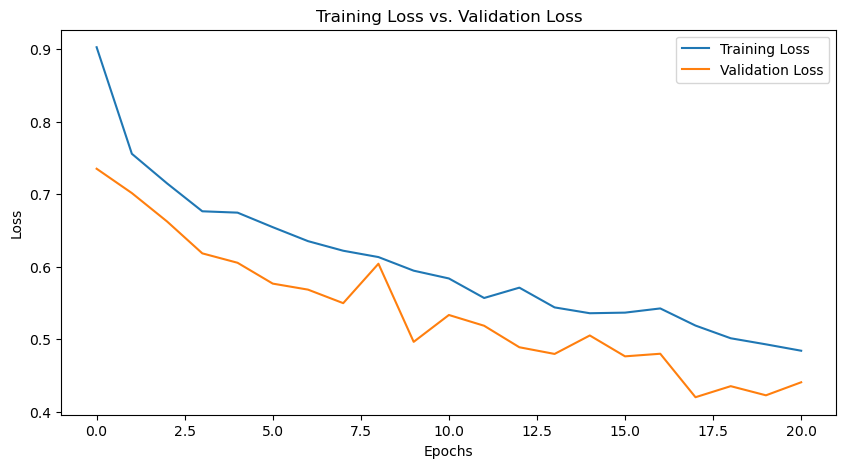

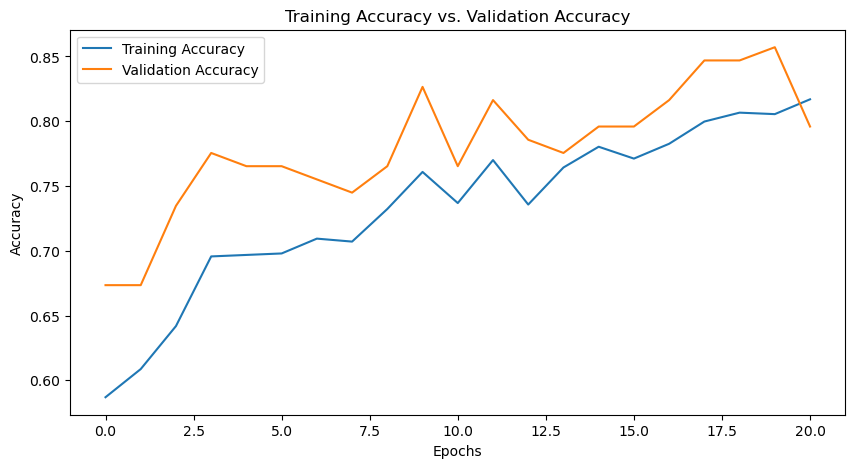

In [25]:
# Plot the training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Validation Loss')
    plt.legend()
    plt.show()

# Plot the training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy vs. Validation Accuracy')
    plt.legend()
    plt.show()

# Call the plot_loss and plot_accuracy functions
plot_loss(history)
plot_accuracy(history)



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step


2024-05-29 16:42:55.008027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-29 16:42:55.054502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


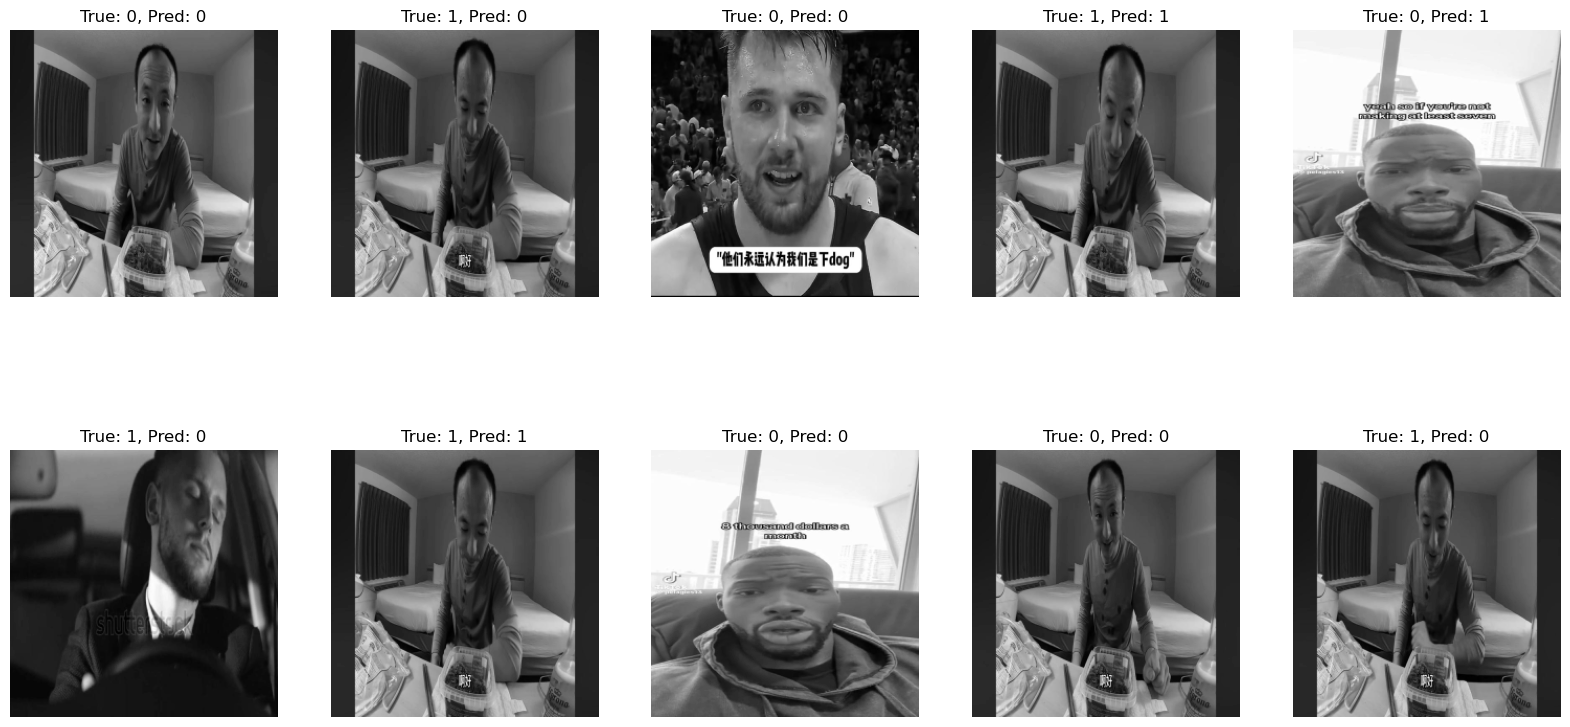

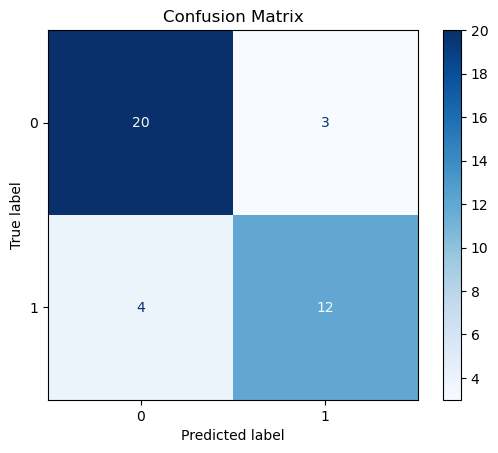

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to visualize random predictions
def visualize_random_predictions(test_ds, predicted_labels):
    # Shuffle the test dataset
    shuffled_test_ds = test_ds.unbatch().shuffle(buffer_size=len(predicted_labels))

    plt.figure(figsize=(20, 10))
    for i, (image, true_label) in enumerate(shuffled_test_ds.take(10)):  # Displaying 10 random images
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(image.numpy().squeeze(), cmap='gray')
        pred_label = predicted_labels[i]
        plt.title(f"True: {true_label.numpy()}, Pred: {pred_label}")
        plt.axis("off")
    plt.show()

# Make predictions on the test set
predictions = model.predict(test_ds)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Extract true labels from the test set
true_labels = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Visualize 10 random predictions
visualize_random_predictions(test_ds, predicted_labels)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
def plot_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(cm)
